In [1]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt

#from Sparse_vector.Sparse_vector import SparseVector
#rom sparse_vector import SparseVector as sparse_vector
import sparse_vector

In [2]:
!git clone https://github.com/Nazar1997/DeepZ_data_creation

Cloning into 'DeepZ_data_creation'...
remote: Enumerating objects: 1363, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1363 (delta 0), reused 0 (delta 0), pack-reused 1360
Receiving objects: 100% (1363/1363), 1.34 GiB | 25.66 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Checking out files: 100% (1140/1140), done.


In [2]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('DeepZ_data_creation/data/hg19_features/sparse/') if i.endswith('.pkl')]

In [3]:
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features if (i.split('_')[0] in groups)]

def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'DeepZ_data_creation/data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"DeepZ_data_creation/data/hg19_dna/{file}") for file in files])

In [4]:
%%time
# load all the data
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}
ZDNA = load('DeepZ_data_creation/data/hg19_zdna/sparse/ZDNA.pkl')
ZHUNT = load('DeepZ_data_creation/data/hg19_zdna/sparse/ZHUNT.pkl')

DNA_features = {feture: load(f'DeepZ_data_creation/data/hg19_features/sparse/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

CPU times: user 16 s, sys: 4.93 s, total: 20.9 s
Wall time: 36.2 s


# All DL code

In [5]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [6]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels_source, intervals):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        
    def __len__(self):
        return len(self.intervals)
    
    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        
        return (X, y)
        
        

In [7]:
width = 5000

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chroms:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████| 3/3 [00:00<00:00, 9118.05it/s]


In [8]:
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

In [9]:
train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem 
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

train_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals)

test_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [10]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepZ(nn.Module):
    def __init__(self):
        super().__init__()
       # self.cnn1 = nn.Conv2d(1, 1, kernel_size=(10, 1058), stride=(2,1), padding=(1,0))
        self.cnn2 =	nn.Conv2d(5000, 5000, kernel_size=(5,1), stride=(2,1), padding=(1,0))
        # self.seq = nn.Sequential(
        #             nn.Dropout(0.5),
        #             nn.Linear(2 * 500, 500),
        #             nn.Sigmoid(),
        #             nn.Dropout(0.5),
        #             nn.Linear(500, 2)
        # )
        self.seq1 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False),
            nn.Dropout(p=0.1))
        self.seq2 = nn.Sequential(
            nn.Linear(in_features=528, out_features=100, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=100, out_features=2, bias=True)
        )
    
    def forward(self, x):
        batch = x.shape[0]
      #  x1 = x.reshape((batch, 1, 5000, 1058))
       # x1 = self.cnn1(x1)
       # print(x1.shape)
        x1 = x.reshape((batch, 5000, 1058, 1))
        x1 = self.cnn2(x1)
        x1 = x1.reshape((batch, 5000, 528, 1))
        x1 = self.seq1(x1)
        x1 = x1.reshape((batch, 5000, 528))
        x1 = self.seq2(x1)
        x1 = F.log_softmax(x1, dim=-1)
        return x1

In [11]:
import tqdm

params = {'batch_size':24,
          'num_workers':0,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)
    
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)



def train_epoch(model, optimizer):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.train()
    for _, (X_batch, y_batch) in enumerate(tqdm.tqdm(loader_train)):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten()
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def test(model):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in loader_test:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        pred = torch.argmax(output, dim=2)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log, train_auc_log, train_f1_log = [], [], [], []
    val_log,   val_acc_log,   val_auc_log, val_f1_log   = [], [], [], []
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_loss, train_acc, train_auc, train_f1 = train_epoch(model, opt)
        val_loss, val_acc, val_auc, val_f1 = test(model)
        
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
#         raise BaseException
        
        if (epoch % 1) == 0:
            clear_output()
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize)
            plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
            print("Epoch {} AUC = {:.2%}".format(epoch+1, 1 - val_auc_log[-1]))
            print("Epoch {} accuracy = {:.2%}".format(epoch+1, 1 - val_acc_log[-1]))
            print(np.mean(train_acc))
            
            
    print("Final AUC: {:.2}".format(1 - val_auc_log[-1]))

In [12]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [13]:
model = DeepZ()
model = model.cuda()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 125058102


In [14]:
torch.cuda.empty_cache()

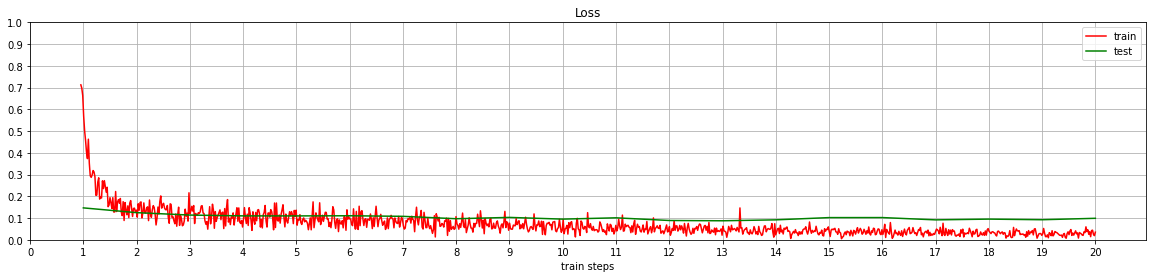

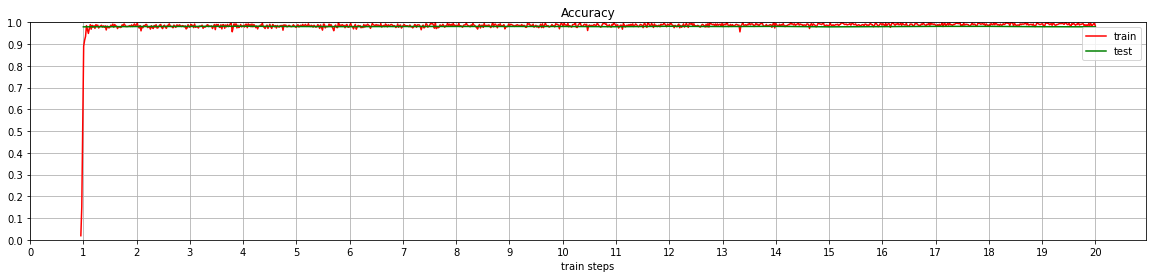

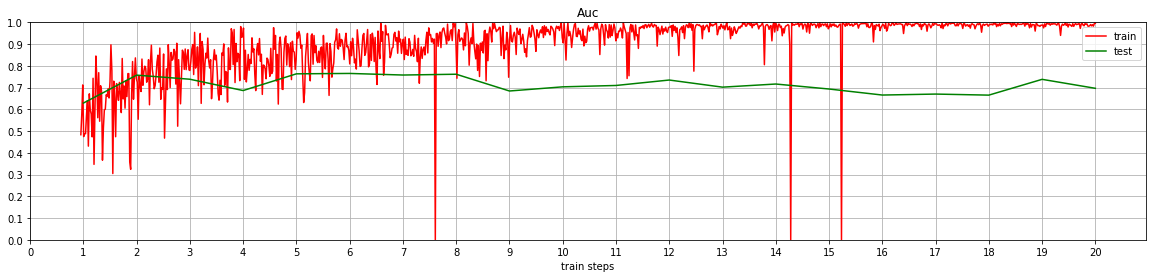

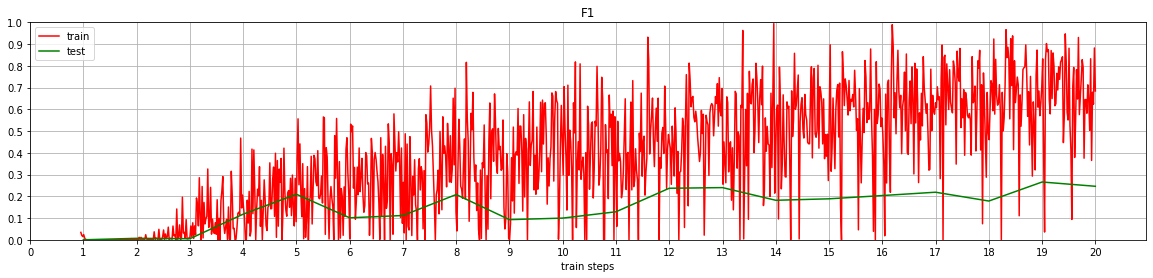

Epoch 20 AUC = 30.33%
Epoch 20 accuracy = 2.05%
0.99133694
Final AUC: 0.3


In [15]:
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)
train(model, opt, 20)

In [17]:
#torch.save(model.state_dict(), 'go1.pt')

In [33]:
model.load_state_dict(torch.load( 'go1.pt'))

<All keys matched successfully>

In [16]:
for _, (X_batch, y_batch) in enumerate(tqdm.tqdm(loader_train)):
        x = X_batch.cuda()
        break
x = x[0].reshape((1, 5000, 1058))

  0%|          | 0/54 [00:02<?, ?it/s]


In [17]:
from src.lrp import LRPModel
lrp_model = LRPModel(model)

In [ ]:
%load_ext autoreload
%reload_ext autoreload

In [18]:
activations = list()
with torch.no_grad():
            # Replace image with ones avoids using image information for relevance computation.
            activations.append(torch.ones_like(x))
            #x1 = x.reshape((1, 1, 5000, 1058))
            #x1 = model.cnn1(x1)
            #activations.append(x1)
            #print(x.shape)
            x1 = x.reshape((1, 5000, 1058, 1))
            x1 = model.cnn2(x1)
            print(x1.shape)
            activations.append(x1)
            x1 = x1.reshape((1, 5000, 528, 1))
            for layer in model.seq1:
                x1 = layer.forward(x1)
                activations.append(x1)
            x1 = x1.reshape((1, 5000, 528))
            activations[-1] = activations[-1].reshape((1, 5000, 528))
            for layer in model.seq2:
                x1 = layer.forward(x1)
                activations.append(x1)
        # Reverse order of activations to run backwards through model
            activations = activations[::-1]
            activations[-1] = activations[-1].reshape((1, 5000, 1058, 1))
            activations = [a.data.requires_grad_(True) for a in activations]

torch.Size([1, 5000, 528, 1])


In [19]:
for i in activations:
  print(i.shape)

torch.Size([1, 5000, 2])
torch.Size([1, 5000, 100])
torch.Size([1, 5000, 100])
torch.Size([1, 5000, 100])
torch.Size([1, 5000, 528])
torch.Size([1, 5000, 528, 1])
torch.Size([1, 5000, 528, 1])
torch.Size([1, 5000, 528, 1])
torch.Size([1, 5000, 1058, 1])


In [20]:
layers = torch.nn.ModuleList()
layers.append(model.cnn2)
for layer in model.seq1:
    layers.append(layer)
for layer in model.seq2:
    layers.append(layer)
layers = layers[::-1]

In [21]:
relevance = torch.softmax(activations.pop(0), dim=-1)  # Unsupervised

        # Perform relevance propagation
for i, layer in enumerate(lrp_model.lrp_layers):
    print('*' * 100)
    print('Activation:')
    print(activations[0].shape)
    print('Relevance:')
    print(relevance.shape)
    print("Layer:")
    print(layer)
    print(layers[i].forward(activations[0]).shape)
    print('*' * 100)
    relevance = layer.forward(activations.pop(0), relevance)

****************************************************************************************************
Activation:
torch.Size([1, 5000, 100])
Relevance:
torch.Size([1, 5000, 2])
Layer:
RelevancePropagationLinear(
  (layer): Linear(in_features=100, out_features=2, bias=True)
)
torch.Size([1, 5000, 2])
****************************************************************************************************
****************************************************************************************************
Activation:
torch.Size([1, 5000, 100])
Relevance:
torch.Size([5000, 100])
Layer:
RelevancePropagationDropout()
torch.Size([1, 5000, 100])
****************************************************************************************************
****************************************************************************************************
Activation:
torch.Size([1, 5000, 100])
Relevance:
torch.Size([5000, 100])
Layer:
RelevancePropagationReLU()
torch.Size([1, 5000, 100])
***********************

In [22]:
answ = relevance.reshape((5000, 1058))

In [23]:
x_answ = x.reshape((1, 5000, 1058))

In [24]:
x_answ[0].shape

torch.Size([5000, 1058])

In [25]:
r = lrp_model.forward(x)

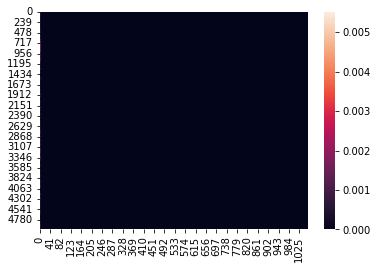

In [26]:
import seaborn as sns
sns.heatmap(answ.cpu())